# Consumer Sentiment: Uber Supply side analysis

### Mainly focusing on how the sentiments have changed with the introduction of In-App Tiping

The main two sources of data:
   * [Indeed](https://www.indeed.com/cmp/Uber-Partner-Drivers/reviews?fjobtitle=Driver+(Independent+Contractor))
   * [Uberpeople](https://uberpeople.net/forums/Gratuity/)
   
   
We plan to use the Indeed reviews to build a classifier model to classify the sentiment of the text given a set of words. The class is defined as positive or negative based on the star ratings for the review which is weighed using the up_vote and down_votes

In [1]:
#calling all the dependencies
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
from nltk import bigrams
from nltk.corpus import stopwords
from nltk import word_tokenize
import string
import re
import us
import numpy as np
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from collections import Counter
from nltk.tokenize import word_tokenize
from nltk import bigrams, FreqDist

C:\ProgramData\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)
C:\ProgramData\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)


In [2]:
data = pd.read_csv('indeed_uber_data_final.csv') #reading the scraped data

In [3]:
data = data.drop('Unnamed: 0', axis = 1)

In [4]:
data.head() #displaying the first 5 rows of data

,ratings,location,date,pro,con,up_vote,down_vote,message
0,3.0,"Boston, MA",2019-02-13,NaN,NaN,4.0,NaN,Initially was excellent. Has become saturated ...
1,3.0,"Paterson, NJ",2019-03-17,Diver,Some area are bad and u safe,NaN,NaN,I like the job but doesn’t pay what I need to ...
2,4.0,"Houston, TX",2019-03-16,get familiar with the city and surrounding area,"maintenance on car, mileage adds up. Sometimes...",NaN,NaN,Only 2 reasons I am quitting is not enough mon...
3,5.0,"Santa Ana, CA",2019-03-16,NaN,NaN,NaN,NaN,Uber is a great job where you can communicate ...
4,5.0,"Tucson, AZ",2019-03-14,Work when I want to,Traffic hours,NaN,NaN,"Monday, Wednesday, Friday, Saturday and Sunday..."


In [5]:
print("Number of driver reviews: " + str(data.shape[0]))

Number of driver reviews: 4343


Text(0.5,1,'Frequence map for Ratings')

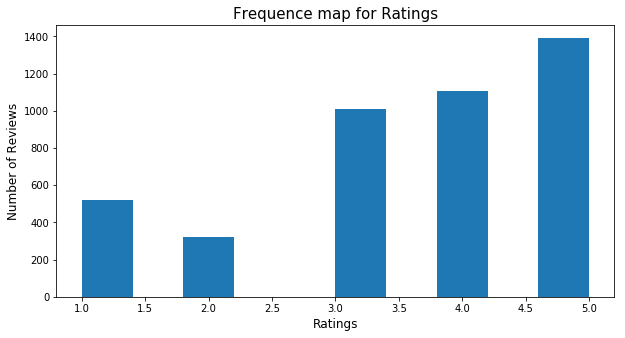

In [6]:
#plot to see the distribution of ratings across the board
plt.figure(figsize=(10,5))
plt.hist(data.ratings)
plt.xlabel('Ratings', size = 12)
plt.ylabel('Number of Reviews', size = 12)
plt.title('Frequence map for Ratings', size = 15)

In [7]:
data.groupby(['ratings'])['message'].count()

ratings
1.0     519
2.0     319
3.0    1009
4.0    1104
5.0    1392
Name: message, dtype: int64

#### We see that the number of 4 & 5 star ratings are more than the lower ratings. Using the theory of loss aversion we would take the ratings equal to or higher than 4 as positive and lower of equal than 3 as negative

In [8]:
data.dtypes #checking the data types of the data colums

ratings      float64
location      object
date          object
pro           object
con           object
up_vote      float64
down_vote    float64
message       object
dtype: object

### Data cleaning

This is a necessary step in natural language processing as this reduces the noise in the data drastically

In [9]:
#getting the states from the location column
data['location'] = data['location'].str.lower()
data['location'] = data['location'].str.replace('\d+','')
data['location'] = data['location'].str.strip()

In [10]:
abr = [state.abbr.lower() for state in us.states.STATES] #list of all US state abbrevations

In [11]:
data['states'] = [state[-2:].strip() for state in data.location] #extracting states from location specified

In [12]:
#some states do not have abbreviations but the entier state name
#this loop gets the abbreviations for those states using US library in python to get data
i = 0
del_index = []
for state in data.states:
    if state in abr:
        i+=1
    elif us.states.lookup(data.at[i,'location']) is None:
        del_index.append(i)
        i+=1
    else:
        data.at[i,'states'] = us.states.lookup(data.at[i,'location']).abbr.lower()
        i+=1

In [13]:
#some states are not from unites states, we remove those values as our focus is only on United States
data.drop(del_index, inplace= True)
data.reset_index(inplace=True, drop=True) 

In [14]:
data.nunique() #number of unique entries in each column

ratings         5
location      756
date         1242
pro          1691
con          2143
up_vote       154
down_vote     109
message      3979
states         50
dtype: int64

In [15]:
#imputing the missing values
data[['pro', 'con']] = data[['pro', 'con']].fillna('')
data[['up_vote', 'down_vote']] = data[['up_vote', 'down_vote']].fillna(0)

In [16]:
data.isna().sum() #check if all the "NaN" values have be filled

ratings      0
location     0
date         0
pro          0
con          0
up_vote      0
down_vote    0
message      0
states       0
dtype: int64

In [17]:
data.head() #ensuring the fucntions act as we want them to

,ratings,location,date,pro,con,up_vote,down_vote,message,states
0,3.0,"boston, ma",2019-02-13,,,4.0,0.0,Initially was excellent. Has become saturated ...,ma
1,3.0,"paterson, nj",2019-03-17,Diver,Some area are bad and u safe,0.0,0.0,I like the job but doesn’t pay what I need to ...,nj
2,4.0,"houston, tx",2019-03-16,get familiar with the city and surrounding area,"maintenance on car, mileage adds up. Sometimes...",0.0,0.0,Only 2 reasons I am quitting is not enough mon...,tx
3,5.0,"santa ana, ca",2019-03-16,,,0.0,0.0,Uber is a great job where you can communicate ...,ca
4,5.0,"tucson, az",2019-03-14,Work when I want to,Traffic hours,0.0,0.0,"Monday, Wednesday, Friday, Saturday and Sunday...",az


In [18]:
stop_words = stopwords.words('english') + list(string.punctuation) #list of stop words and punctuations

In [19]:
""" this fucntion is used to apply all the cleaning steps to the data text columns"""
def data_cleaning(combined_text):
    text = combined_text.lower() #converts everything to lower case charecters
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)#replaces all the punctuations with none
    text = re.sub('\w*\d\w*', '', text) #removes all the numbers
    text = text.replace('\n','') #replaces all the tab charecters
    text = text.replace('\t','')#replaces all the tab charecters
    text = ' '.join([i for i in word_tokenize(text) if i not in stop_words])
    return text

In [20]:
#the data before cleaning looks like
data.message[0]

'Initially was excellent. Has become saturated now with way too many drivers and fares have been reduc d significantly while the percentage uber receive has increased'

In [21]:
#data_cleaning removes all the punctuations and stop words, this allows us to focus only on meaningfull data
data_cleaning(data.message[0])

'initially excellent become saturated way many drivers fares reduc significantly percentage uber receive increased'

In [22]:
#applying the data cleaner to all the text columns
data['message'] =  data['message'].apply(data_cleaning)
data['pro'] =  data['pro'].apply(data_cleaning)
data['con'] =  data['con'].apply(data_cleaning)

### Creating weighted rating system based on up and down votes

This is done in order to rate the reviews based on their number of up and down votes, we subtract the number of downvotes from upvotes and divide them by the total number of upvotes. Finally the weight is added to the stars given.

In [23]:
#creating a column for weights:
weight = []
for i in range(data.shape[0]):
    w = (data.up_vote[i] - data.down_vote[i])/(data.up_vote[i] + data.down_vote[i])
    weight.append(w)
    
data['weight'] = weight 
data.weight.fillna(0, inplace=True)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in double_scalars
  after removing the cwd from sys.path.


In [180]:
data['weighed_rankings'] = data.ratings+data.weight
data.weighed_rankings.round(2)
data.head()

,ratings,location,date,pro,con,up_vote,down_vote,message,states,weight,weighed_rankings,sentiment
0,3.0,"boston, ma",2019-02-13,,,4.0,0.0,initially excellent become saturated way many ...,ma,1.0,4.0,0
1,3.0,"paterson, nj",2019-03-17,diver,area bad u safe,0.0,0.0,like job ’ pay need liveso ’ looking business ...,nj,0.0,3.0,0
2,4.0,"houston, tx",2019-03-16,get familiar city surrounding area,maintenance car mileage adds sometimes unappre...,0.0,0.0,reasons quitting enough money wear tear car so...,tx,0.0,4.0,0
3,5.0,"santa ana, ca",2019-03-16,,,0.0,0.0,uber great job communicate riders fun conversa...,ca,0.0,5.0,1
4,5.0,"tucson, az",2019-03-14,work want,traffic hours,0.0,0.0,monday wednesday friday saturday sunday usuall...,az,0.0,5.0,1


Text(0.5,1,'Frequence map for weighed rankings')

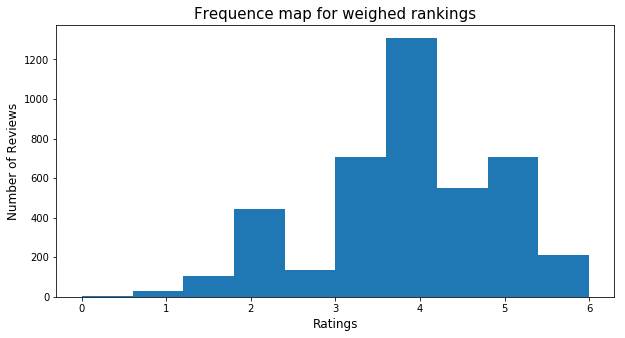

In [192]:
#plot to see the distribution of ratings across the board
plt.figure(figsize=(10,5))
plt.hist(data.weighed_rankings)
plt.xlabel('Ratings', size = 12)
plt.ylabel('Number of Reviews', size = 12)
plt.title('Frequence map for weighed rankings', size = 15)

In [193]:
data.groupby(data.weighed_rankings.round())['message'].count()

weighed_rankings
0.0       3
1.0      40
2.0     562
3.0     733
4.0    1715
5.0     954
6.0     193
Name: message, dtype: int64

In [145]:
def string_bigram_frequency(text_blob):
    
    tokens = word_tokenize(text_blob)
    bi_grams = []
    for txt in list(bigrams(tokens)):
        bi_grams.append((''.join([word + ' ' for word in txt])).strip())
    
    all_tokens = bi_grams + tokens
    count_dict = Counter(all_tokens)
    
    return count_dict

In [153]:
pro_blob = " ".join(["".join(text) for text in data.pro])
con_blob = " ".join(["".join(text) for text in data.con])

In [154]:
pro_count_vector = string_bigram_frequency(pro_blob) 
con_count_vector = string_bigram_frequency(con_blob)

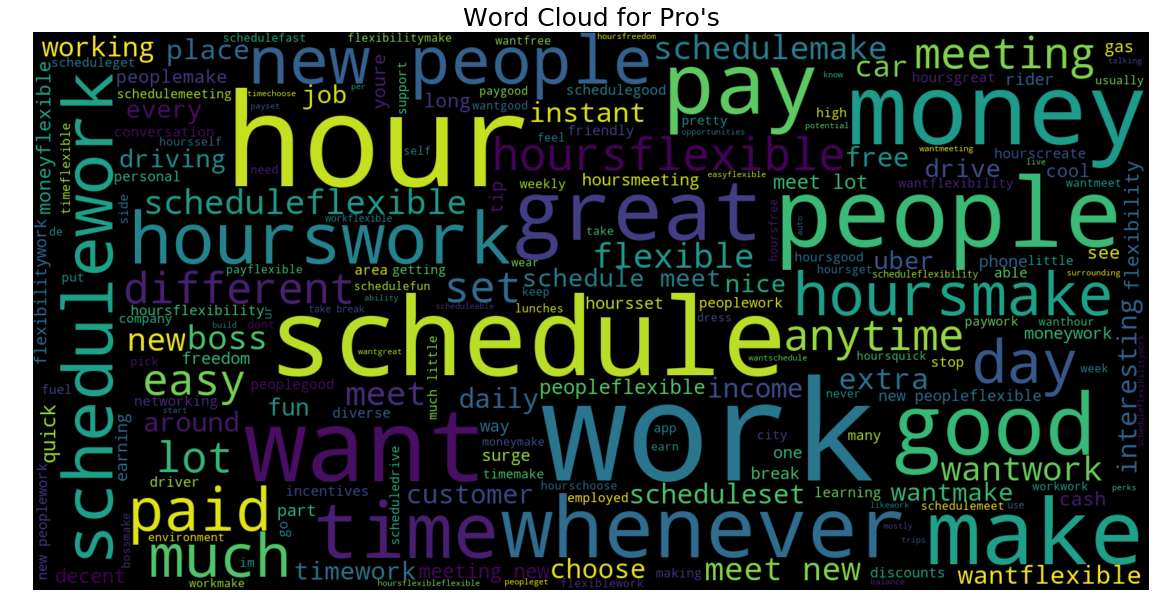

In [69]:
# Display the generated image:
wordcloud_pro = WordCloud(width=1600, height=800, max_font_size=200).generate(pro_blob)
plt.figure(figsize=(20,15))
plt.title("Word Cloud for Pro's", size = 25)
plt.imshow(wordcloud_pro, interpolation='bilinear')
plt.axis("off")
plt.show()

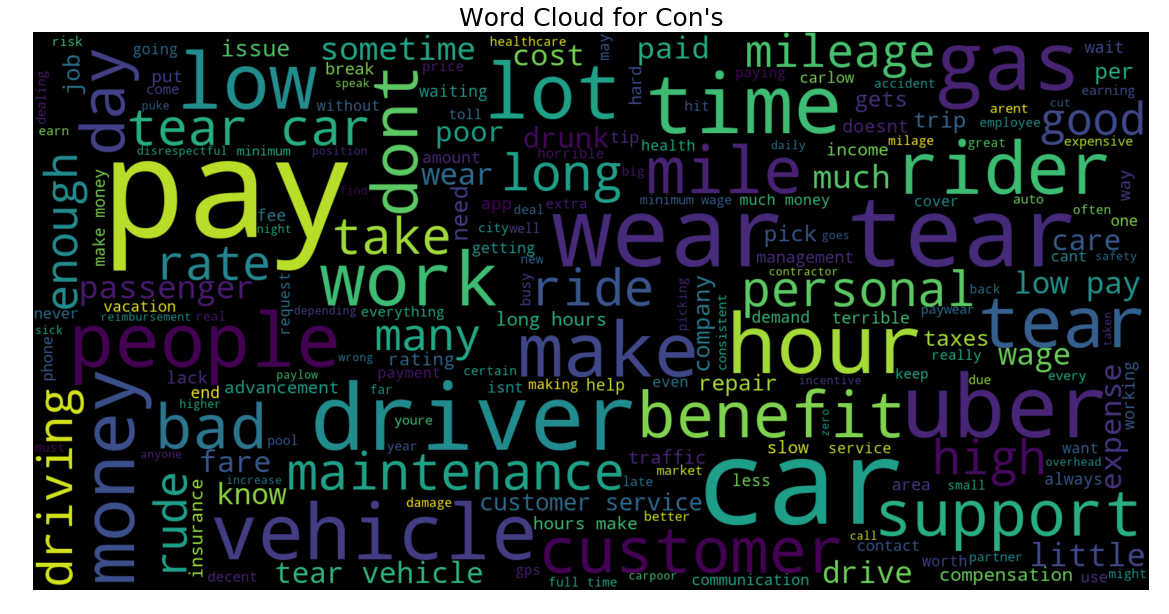

In [70]:
# Display the generated image:
wordcloud_pro = WordCloud(width=1600, height=800, max_font_size=200).generate(con_blob)
plt.figure(figsize=(20,15))
plt.title("Word Cloud for Con's", size = 25)
plt.imshow(wordcloud_pro, interpolation='bilinear')
plt.axis("off")
plt.show()

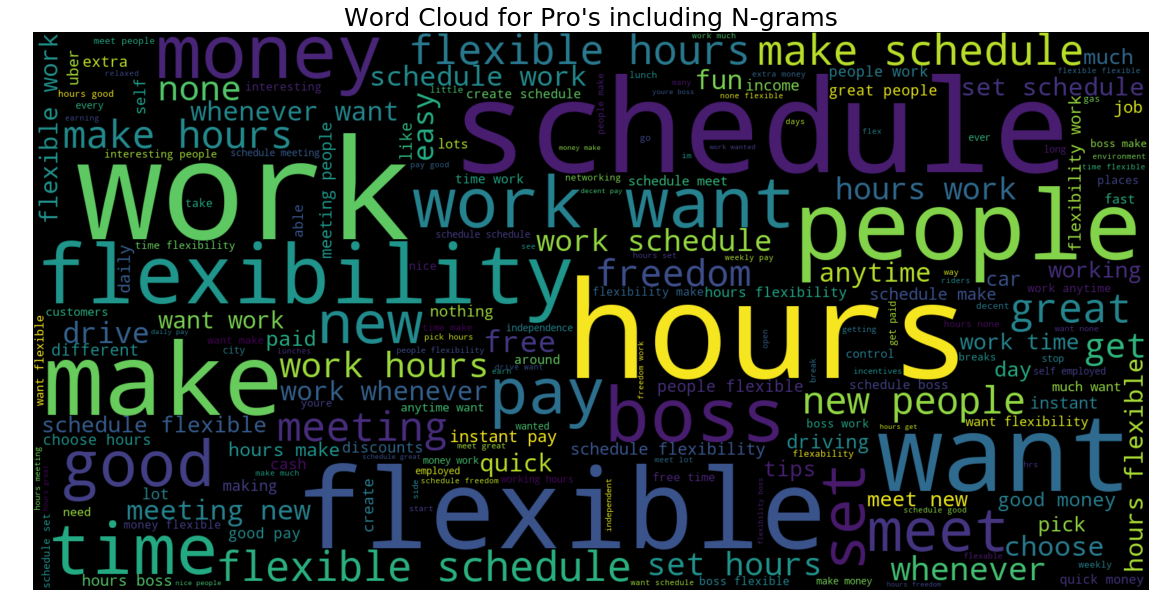

In [155]:
# Display the generated image:
wordcloud_pro = WordCloud(width=1600, height=800, max_font_size=200).fit_words(pro_count_vector)
plt.figure(figsize=(20,15))
plt.title("Word Cloud for Pro's including N-grams", size = 25)
plt.imshow(wordcloud_pro, interpolation='bilinear')
plt.axis("off")
plt.show()

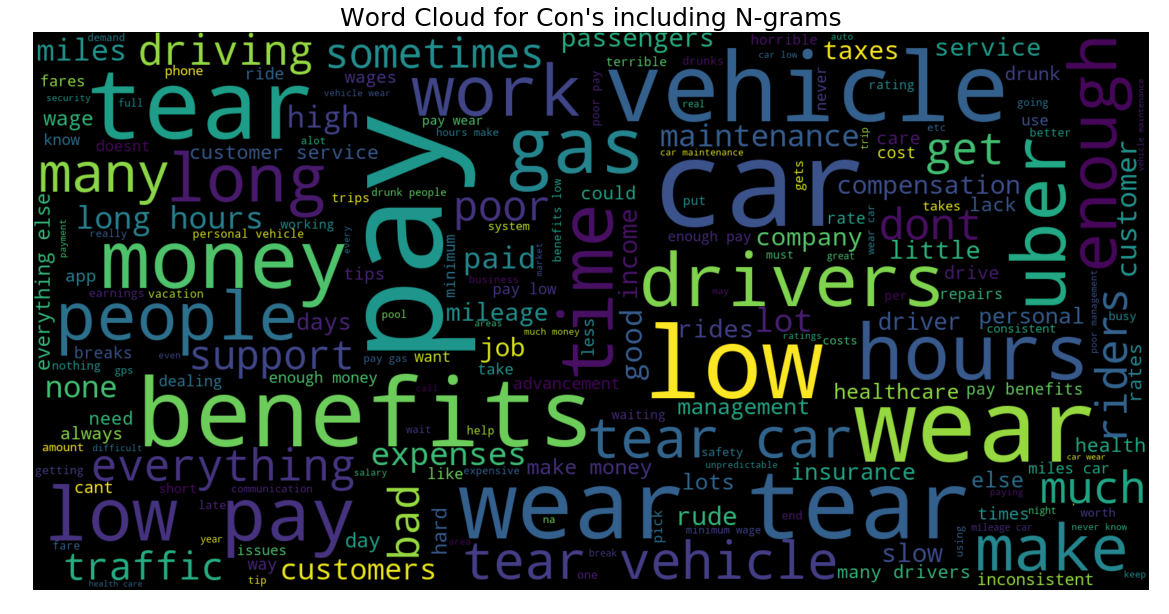

In [158]:
# Display the generated image:
wordcloud_pro = WordCloud(width=1600, height=800, max_font_size=200).fit_words(con_count_vector)
plt.figure(figsize=(20,15))
plt.title("Word Cloud for Con's including N-grams", size = 25)
plt.imshow(wordcloud_pro, interpolation='bilinear')
plt.axis("off")
plt.show()

### Data Sentiment

For the sake of simlicity, in the first pass we describe all the ratings below the 3.0 mark as a negative sentiment and anything above 3.0 as a positive rating. This decission was made by following the principles of loss aversion curve by Kahneman.

In [246]:
sentiment = []

for rating in data.ratings:
    if rating > 3.0:
        sentiment.append(1)
    else:
        sentiment.append(0)
        
data['sentiment'] = sentiment        

In [247]:
data.head()

,ratings,location,date,pro,con,up_vote,down_vote,message,states,weight,weighed_rankings,sentiment
0,3.0,"boston, ma",2019-02-13,,,4.0,0.0,initially excellent become saturated way many ...,ma,1.0,4.0,0
1,3.0,"paterson, nj",2019-03-17,diver,area bad u safe,0.0,0.0,like job ’ pay need liveso ’ looking business ...,nj,0.0,3.0,0
2,4.0,"houston, tx",2019-03-16,get familiar city surrounding area,maintenance car mileage adds sometimes unappre...,0.0,0.0,reasons quitting enough money wear tear car so...,tx,0.0,4.0,1
3,5.0,"santa ana, ca",2019-03-16,,,0.0,0.0,uber great job communicate riders fun conversa...,ca,0.0,5.0,1
4,5.0,"tucson, az",2019-03-14,work want,traffic hours,0.0,0.0,monday wednesday friday saturday sunday usuall...,az,0.0,5.0,1


Text(0.5,1,'Frequence map of Sentiments')

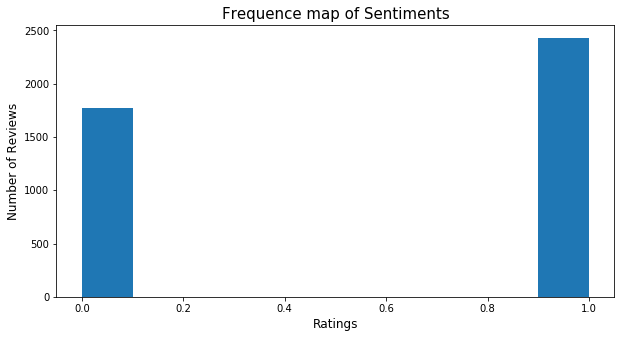

In [248]:
#plot to see the distribution of ratings across the board
plt.figure(figsize=(10,5))
plt.hist(data.sentiment)
plt.xlabel('Ratings', size = 12)
plt.ylabel('Number of Reviews', size = 12)
plt.title('Frequence map of Sentiments', size = 15)

### Creating a baseline model for sentiment classification

In [249]:
#importing all the dependencies.
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [250]:
cv = CountVectorizer()

In [251]:
features = cv.fit_transform(data.message)

In [252]:
target = data.sentiment.values

In [253]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2)

In [254]:
model = LogisticRegression(C=0.2, dual=True)
model.fit(X_train, y_train)
preds = model.predict(X_test)
accuracy = (preds == y_test).mean()

In [255]:
print(f"The model accuracy is: {round(accuracy*100,2)}%")

The model accuracy is: 76.19%


### Creating visualizations for understanding the model working

In [256]:
#function to get the most important features in both the classes
def get_most_important_features(vectorizer, model, n=5):
    index_to_word = {v:k for k,v in vectorizer.vocabulary_.items()}
    
    # loop for each class
    classes ={}
    for class_index in range(model.coef_.shape[0]):
        word_importances = [(el, index_to_word[i]) for i,el in enumerate(model.coef_[class_index])]
        sorted_coeff = sorted(word_importances, key = lambda x : x[0], reverse=True)
        tops = sorted(sorted_coeff[:n], key = lambda x : x[0])
        bottom = sorted_coeff[-n:]
        classes[class_index] = {
            'tops':tops,
            'bottom':bottom
        }
    return classes

In [257]:
importance  = get_most_important_features(cv,model,10)

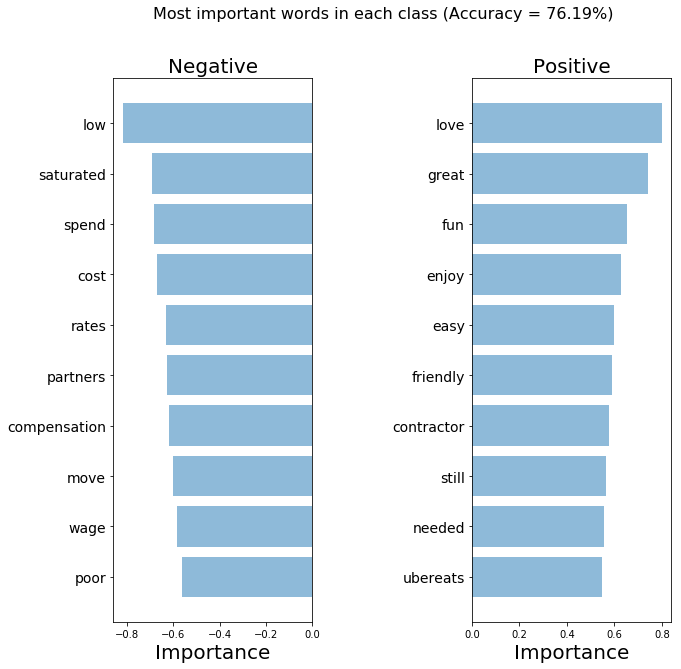

In [258]:
#function to plot the top 10 important words in the bag of words
def plot_important_words(top_scores, top_words, bottom_scores, bottom_words, name):
    y_pos = np.arange(len(top_words))
    top_pairs = [(a,b) for a,b in zip(top_words, top_scores)]
    top_pairs = sorted(top_pairs, key=lambda x: x[1])
    
    bottom_pairs = [(a,b) for a,b in zip(bottom_words, bottom_scores)]
    bottom_pairs = sorted(bottom_pairs, key=lambda x: x[1], reverse=True)
    
    top_words = [a[0] for a in top_pairs]
    top_scores = [a[1] for a in top_pairs]
    
    bottom_words = [a[0] for a in bottom_pairs]
    bottom_scores = [a[1] for a in bottom_pairs]
    
    fig = plt.figure(figsize=(10, 10))  

    plt.subplot(121)
    plt.barh(y_pos,bottom_scores, align='center', alpha=0.5)
    plt.title('Negative', fontsize=20)
    plt.yticks(y_pos, bottom_words, fontsize=14)
    plt.suptitle('Key words', fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    
    plt.subplot(122)
    plt.barh(y_pos,top_scores, align='center', alpha=0.5)
    plt.title('Positive', fontsize=20)
    plt.yticks(y_pos, top_words, fontsize=14)
    plt.suptitle(name, fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    
    plt.subplots_adjust(wspace=0.8)
    plt.show()

top_scores = [a[0] for a in importance[0]['tops']]
top_words = [a[1] for a in importance[0]['tops']]
bottom_scores = [a[0] for a in importance[0]['bottom']]
bottom_words = [a[1] for a in importance[0]['bottom']]

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, f"Most important words in each class (Accuracy = {round(accuracy*100,2)}%)")

### Observations:

The accuracy soo far has not been great, also the words having same or similar meanings have been listed together which is not desirable.

## In the next steps:

* Use weighted methods to define labels
* Use stemmers to get better set of predictors 
* Use N-Grams to understand the combination of words 
* Use model to classify the sentiment over the Uberpeople Data
* Apply topic modelling techniques to come up with bins to understand the reasons for increase / decrease in sentiment score with the Uberpeople data
* Perform time dependent analysis for better understanding


#### If time permits:
* Do similar analysis for Lyft and compare the services

# Thank You!